In [1]:
import os, sys
import yaml

cwd = os.getcwd()
sys.path.append(os.path.dirname(cwd))
from utils import layers_residual
from utils import layers_new
from utils import models_generator as models_gen
from utils import models_discriminator as models_dis
from utils import models_cyclegan as models_gan
from utils import preprocessing as pre
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import sklearn
import seaborn as sns

In [6]:
model_input = tf.keras.layers.Input(shape=(512,21))
mod = [layers_residual.residual_mod(64, 9,strides=1,dilation=1,constrains = None,l1=0.0, l2=0.0,rate = 0.2,use_bias=False,norm="Instance",sn = False,act="LReLU"),
       layers_residual.residual_mod(64, 9,strides=1,dilation=1,constrains = None,l1=0.0, l2=0.0,rate = 0.2,use_bias=False,norm="Instance",sn = False,act="LReLU"),
       layers_residual.residual_mod(64, 9,strides=1,dilation=1,constrains = None,l1=0.0, l2=0.0,rate = 0.2,use_bias=False,norm="Instance",sn = False,act="LReLU"),
      layers_residual.residual_mod(64, 9,strides=1,dilation=1,constrains = None,l1=0.0, l2=0.0,rate = 0.2,use_bias=False,norm="Instance",sn = False,act="LReLU")]


att = layers_new.SelfAttention(64)
x = model_input
x = mod[0](x)
x = att(x)[0]
for i in range(3):
    x_out  = mod[1+i](x)
    x = tf.keras.layers.Add()([x_out, x])
    
model = tf.keras.Model(inputs=model_input, outputs=x)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 512, 21)]    0                                            
__________________________________________________________________________________________________
sequential_12 (Sequential)      (None, 512, 64)      49130       input_4[0][0]                    
__________________________________________________________________________________________________
attention (SelfAttention)       ((None, 512, 64), (N 16641       sequential_12[0][0]              
__________________________________________________________________________________________________
sequential_13 (Sequential)      (None, 512, 64)      73984       attention[0][0]                  
____________________________________________________________________________________________

In [4]:
model_input = tf.keras.layers.Input(shape=(512,21))
mod = layers_residual.residual_mod(64, 9,strides=1,dilation=1,constrains = None,l1=0.0, l2=0.0,rate = 0.2,use_bias=False,norm="Batch",sn = True,act="ReLU")

mod(model_input)
mod.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization (BatchNo (None, 512, 21)           84        
_________________________________________________________________
re_lu (ReLU)                 (None, 512, 21)           0         
_________________________________________________________________
spectral_normalization (Spec (None, 512, 64)           12160     
_________________________________________________________________
batch_normalization_1 (Batch (None, 512, 64)           256       
_________________________________________________________________
re_lu_1 (ReLU)               (None, 512, 64)           0         
_________________________________________________________________
spectral_normalization_1 (Sp (None, 512, 64)           36928     
Total params: 49,428
Trainable params: 49,130
Non-trainable params: 298
__________________________________________________

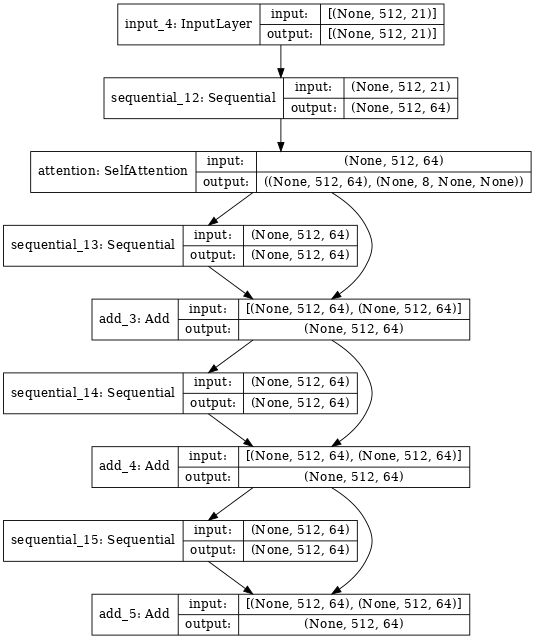

In [7]:
tf.keras.utils.plot_model(model, show_shapes=True, dpi=64)

[256, 256, 256, 256, 256, 256, 256, 256, 256]
8
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 512, 21)]    0                                            
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 512, 64)      12160       input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_18 (BatchNo (None, 512, 64)      256         conv1d[0][0]                     
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 256, 128)     73856       batch_normalization_18[0][0]     
______________________________________________

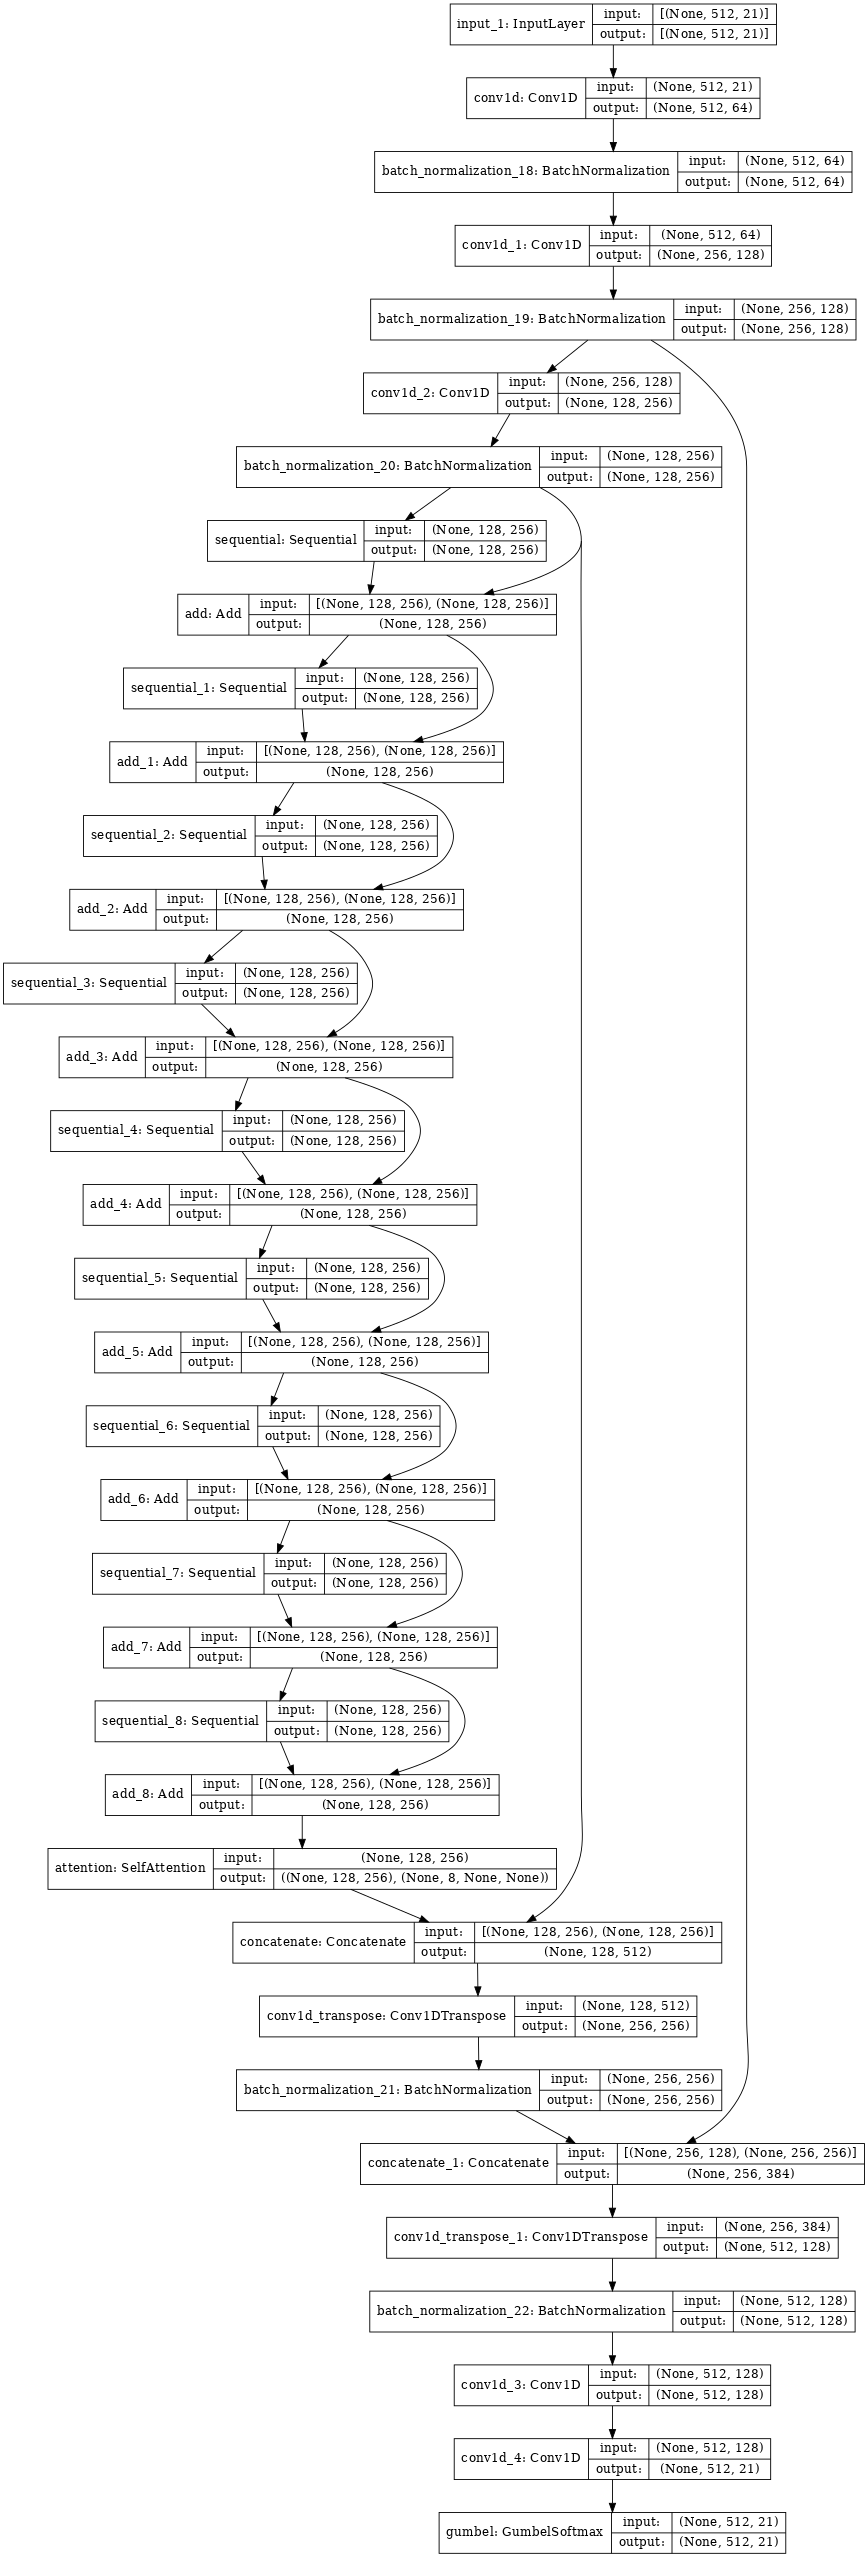

In [2]:
file = "../config/Cycle_gan/config_home.yaml"
with open(file, 'r') as file_descriptor:
    config = yaml.load(file_descriptor, Loader=yaml.FullLoader)
model = models_gen.get_generator(config['CycleGan']['Generator'], 21)
model.summary()
tf.keras.utils.plot_model(model, show_shapes=True, dpi=64)

In [3]:
gms = model.get_layer(index=7)

gms.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
linear_2 (Linear)            (None, 256, 64)           0         
_________________________________________________________________
leaky_re_lu_10 (LeakyReLU)   (None, 256, 64)           0         
_________________________________________________________________
spectral_normalization_20 (S (None, 256, 64)           36992     
_________________________________________________________________
linear_3 (Linear)            (None, 256, 64)           0         
_________________________________________________________________
leaky_re_lu_11 (LeakyReLU)   (None, 256, 64)           0         
_________________________________________________________________
spectral_normalization_21 (S (None, 256, 64)           36992     
Total params: 73,984
Trainable params: 73,856
Non-trainable params: 128
________________________________________________

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 512, 21)]    0                                            
__________________________________________________________________________________________________
spectral_normalization (Spectra (None, 512, 64)      12224       input_1[0][0]                    
__________________________________________________________________________________________________
spectral_normalization_6 (Spect (None, 512, 64)      36992       spectral_normalization[0][0]     
__________________________________________________________________________________________________
sequential (Sequential)         (None, 512, 64)      73984       spectral_normalization_6[0][0]   
______________________________________________________________________________________________

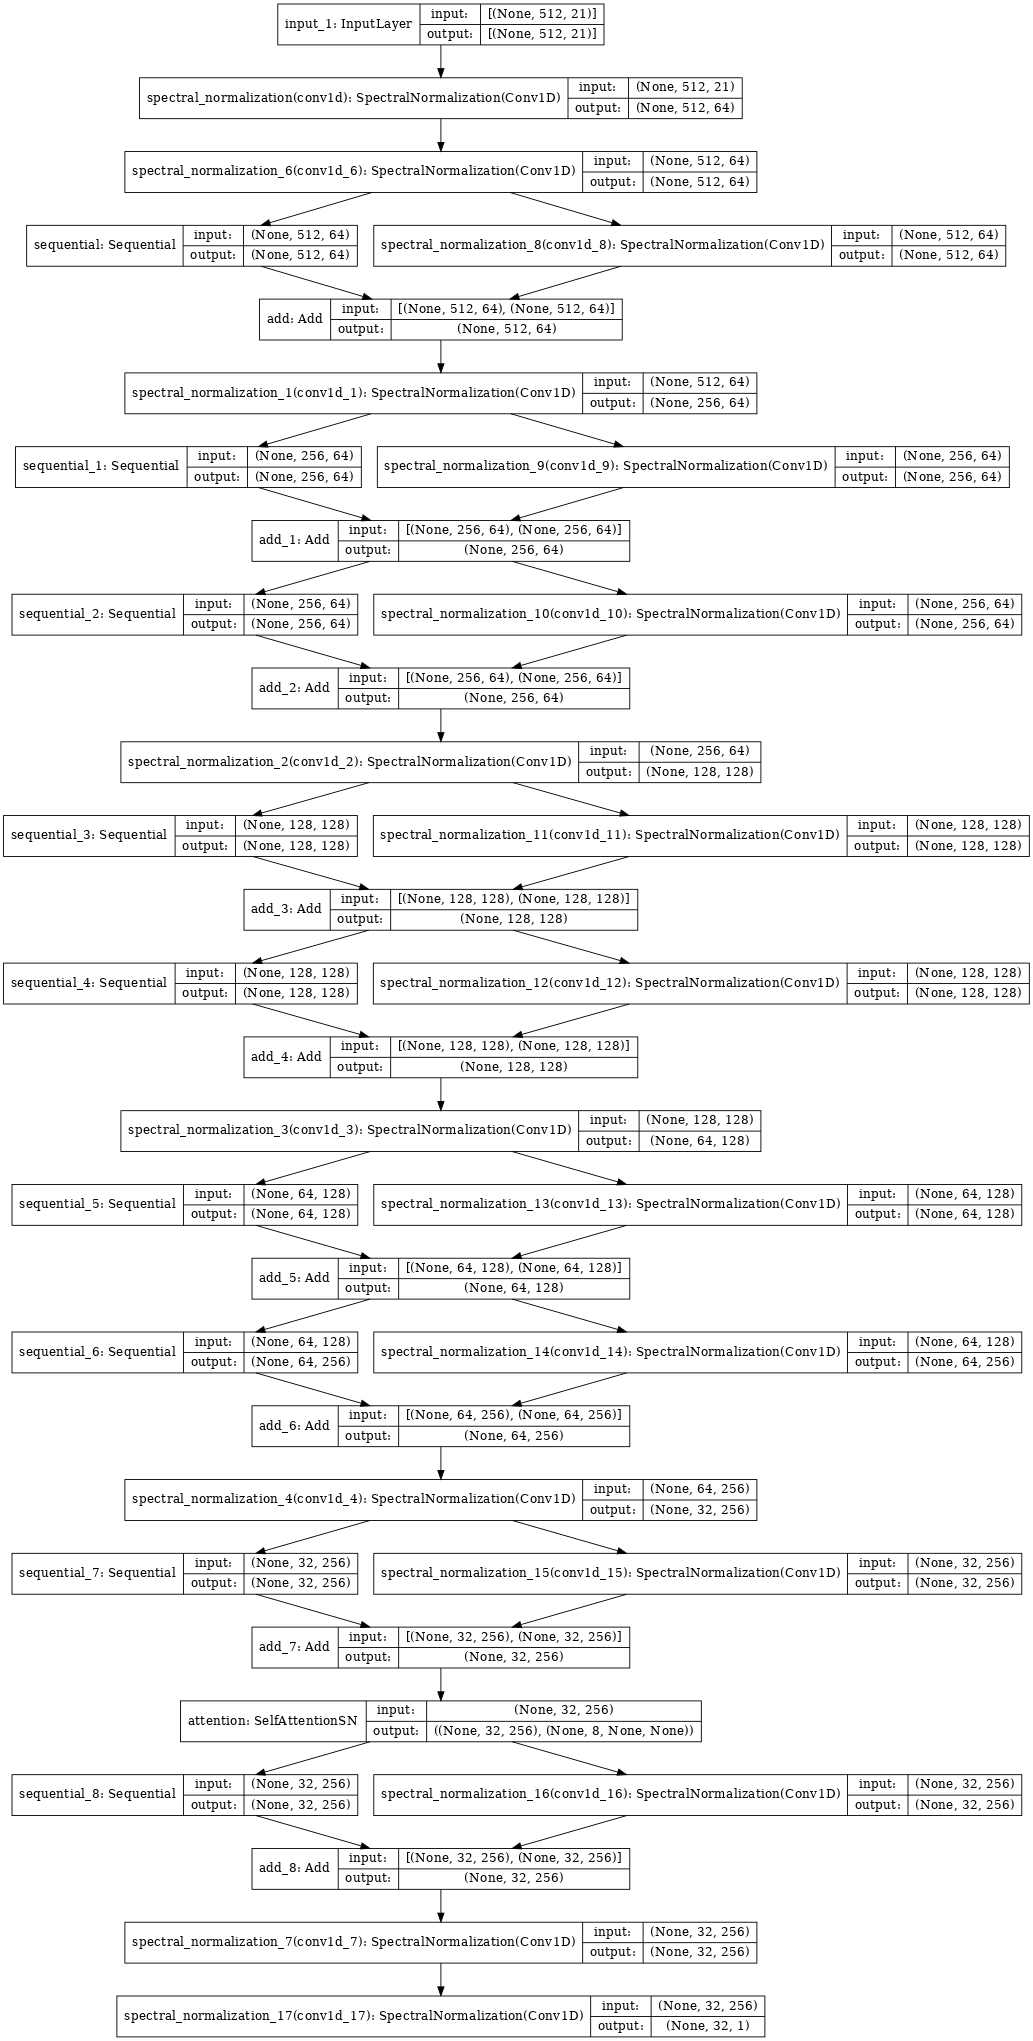

In [2]:
# Load config

file = "../config/Cycle_gan/config_home.yaml"
with open(file, 'r') as file_descriptor:
    config = yaml.load(file_descriptor, Loader=yaml.FullLoader)
model = models_dis.get_discriminator(config['CycleGan']['Discriminator'], 21)
model.summary()
tf.keras.utils.plot_model(model, show_shapes=True, dpi=64)

In [3]:
config["Data"]["base_dir"] = "../data"
config["Data"]["train_dir"] = "Combined_data/published/Groups_5/RECORDS_REG_GLOBAL/train/*.tfrecord"
config["Data"]["val_dir"] = "Combined_data/published/Groups_5/RECORDS_REG_GLOBAL/val/*.tfrecord"

_, data_val = pre.load_data(config["Data"])
data_val = [(i[0], i[1]) for i in data_val.batch(1).as_numpy_iterator()]

for seq, val in data_val:
    ten = model1(seq)
    break
print(ten)

tf.Tensor(
[[[4.9101859e-01 2.7956925e-02 2.1174178e-03 ... 1.0147896e-01
   4.7793142e-03 5.4996848e-02]
  [2.4855126e-01 1.3730978e-03 4.1091954e-03 ... 4.9080228e-04
   9.3110884e-03 2.4887645e-01]
  [2.8153718e-03 2.4949366e-02 6.4874858e-01 ... 4.9024668e-02
   1.2066399e-03 2.5845429e-05]
  ...
  [8.0125566e-05 7.5826648e-04 1.0030077e-02 ... 1.3042762e-04
   2.3690898e-05 1.3959467e-04]
  [1.6432139e-04 1.2928373e-03 1.6995370e-04 ... 1.2760801e-04
   1.4927003e-02 1.4926915e-04]
  [5.7703524e-04 6.3740313e-02 1.7024770e-04 ... 8.1554577e-03
   6.3444309e-02 1.4737853e-03]]], shape=(1, 512, 21), dtype=float32)


In [7]:
model1.get_layer(index = 8).trainable_weights

[<tf.Variable 'dis_therm/dis_thermres_5/dis_thermres_5_conv_1_norm/gamma:0' shape=(256,) dtype=float32, numpy=
 array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1

In [9]:
print(output)

KerasTensor(type_spec=TensorSpec(shape=(None, 64, 1), dtype=tf.float32, name=None), name='dis_therm/dis_therm_conv_out/Sigmoid:0', description="created by layer 'dis_therm'")


In [8]:
model1.save_weights("test1.h5", overwrite = True)

In [9]:
model1.load_weights("test1.h5", by_name = True)

In [19]:
file = "../config/Cycle_gan/config_home.yaml"
with open(file, 'r') as file_descriptor:
    config = yaml.load(file_descriptor, Loader=yaml.FullLoader)
model_input = tf.keras.layers.Input(shape=(512,21))
model1 = models_dis.Discriminator(config['CycleGan']['Discriminator'], vocab = 21, name = "dis_therm")
output = model1(model_input)

In [20]:
model1.summary()

Model: "dis_therm"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dis_therm_proj (Dense)       multiple                  1344      
_________________________________________________________________
dis_therm_input_conv (Conv1D multiple                  36928     
_________________________________________________________________
dis_therm_conv_out (Conv1D)  multiple                  2305      
_________________________________________________________________
dis_thermres_0 (ResModPreAct multiple                  114944    
_________________________________________________________________
dis_thermres_1 (ResModPreAct multiple                  78080     
_________________________________________________________________
dis_thermres_2 (ResModPreAct multiple                  114944    
_________________________________________________________________
dis_thermres_3 (ResModPreAct multiple                  22

In [11]:
file = "../config/Cycle_gan/config_home.yaml"
with open(file, 'r') as file_descriptor:
    config = yaml.load(file_descriptor, Loader=yaml.FullLoader)
model = models_gan.CycleGan(config, name = "gan")

True
Tensor("Placeholder:0", shape=(None, 512, 21), dtype=float32)
[<tf.Tensor 'Generator_thermo/Generator_thermo_up_down_0_norm/batchnorm/add_1:0' shape=(None, 256, 64) dtype=float32>, <tf.Tensor 'Generator_thermo/Generator_thermo_up_down_1_norm/batchnorm/add_1:0' shape=(None, 128, 128) dtype=float32>]
True
Tensor("Placeholder:0", shape=(None, 512, 21), dtype=float32)
[<tf.Tensor 'Generator_meso/Generator_meso_up_down_0_norm/batchnorm/add_1:0' shape=(None, 256, 64) dtype=float32>, <tf.Tensor 'Generator_meso/Generator_meso_up_down_1_norm/batchnorm/add_1:0' shape=(None, 128, 128) dtype=float32>]
Model: "Generator_thermo"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Generator_thermo_gumbel (Gum multiple                  1         
_________________________________________________________________
Generator_thermo_sn_in_proj  multiple                  1408      
__________________________________________

In [12]:
model.save_gan("test")

In [13]:
model.load_gan("test")